# Assignment 1


In [71]:
import numpy as np
np.random.seed(13) #TODO Check if this is used for sgd
import keras.backend as K
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Lambda, Flatten
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing import sequence
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
from matplotlib import pylab
from __future__ import division
import sys

In [72]:
# DO NOT Modify the lines in this cell
path = 'alice.txt'
corpus = open(path).readlines()[0:700]

corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)

nb_samples = sum(len(s) for s in corpus)
V = len(tokenizer.word_index) + 1
dict_tokens = tokenizer.word_index
dict_tokens_reverse = {v: k for k, v in dict_tokens.items()}
# Is this something they need to change?
dim = 100
window_size = 2 #use this window size for Skipgram, CBOW, and the model with the additional hidden layer
window_size_corpus = 4 #use this window size for the co-occurrence matrix

## Question 1

### Co-occurrence Matrix
Use the provided code to load the "Alice in Wonderland" text document. 
1. Implement the word-word co-occurrence matrix for “Alice in Wonderland”
2. Normalize the words such that every value lies within a range of 0 and 1
3. Compute the cosine distance between the given words:
    - Alice 
    - Dinah
    - Rabbit
4. List the 5 closest words to 'Alice'. Discuss the results.
5. Discuss what the main drawbacks are of a term-term co-occurence matrix solutions?


In [73]:
#create co-occurrence matrix
matrix = np.zeros((V,V), dtype=float)
a = 0
maximum = 0.0
for sentence in corpus:
    for index, word in enumerate(sentence):
        j = 1
        while j <= window_size_corpus:
            if index + j < len(sentence) and sentence[index + j] != word:
                matrix[word][sentence[index + j]] = matrix[word][sentence[index + j]] + 1
                if matrix[word][sentence[index + j]] > maximum:
                    maximum = matrix[word][sentence[index + j]]
            if index - j >= 0 and sentence[index - j] != word:
                matrix[word][sentence[index - j]] = matrix[word][sentence[index - j]] + 1
                if matrix[word][sentence[index - j]] > maximum:
                    maximum = matrix[word][sentence[index - j]]
            j = j + 1

            
#normalize all words
for x in range(V):
    for y in range(V):
        matrix[x][y] = float(matrix[x][y]) / float(maximum)
        
f = open('vectors_co_occurrence_analogy.txt',"w")
f.write(" ".join([str(V - 1),str(V)]))
f.write("\n")

#vectors = your word co-occurrence matrix
vectors = []
for word, i in tokenizer.word_index.items():    
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, matrix[i])))
    f.write("\n")
f.close()

matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.93421053, ...,  0.01315789,
         0.        ,  0.        ],
       [ 0.        ,  0.93421053,  0.        , ...,  0.01315789,
         0.01315789,  0.01315789],
       ..., 
       [ 0.        ,  0.01315789,  0.01315789, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.01315789, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.01315789, ...,  0.        ,
         0.        ,  0.        ]])

In [4]:
#find cosine similarity to Alice, Dinah and Rabbit
alice_index = tokenizer.word_index["alice"]
dinah_index = tokenizer.word_index["dinah"]
rabbit_index = tokenizer.word_index["rabbit"]

co_occurrence = KeyedVectors.load_word2vec_format('./vectors_co_occurrence.txt', binary=False)
print("Alice and rabbit", co_occurrence.similarity("alice", "rabbit"))
print("Alice and dinah", co_occurrence.similarity("alice", "dinah"))
print("Rabbit and dinah", co_occurrence.similarity("rabbit", "dinah"))



Alice and rabbit 0.478909301683
Alice and dinah 0.393600110608
Rabbit and dinah 0.298623232265


In [ ]:
#find the closest words to Alice
co_occurrence = KeyedVectors.load_word2vec_format('./vectors_co_occurrence.txt', binary=False)
co_occurrence.similar_by_word("alice", 5)

Discussion of the drawbacks:

- Co-occurence matrix is very large because you set every word in your vocabolary against the other words. 
- Most of the matrix is filled with zeros

In [ ]:
#Save your all the vector representations of your word embeddings in this way
#Change when necessary the sizes of the vocabulary/embedding dimension

f = open('vectors_co_occurrence.txt',"w")
#f.write(" ".join([str(V - 1),str(V - 1)]))
f.write(" ".join([str(V - 1),str(V)]))
f.write("\n")

#vectors = your word co-occurrence matrix
vectors = []
for word, i in tokenizer.word_index.items():    
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, matrix[i])))
    #f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

In [7]:
#reopen your file as follows

co_occurrence = KeyedVectors.load_word2vec_format('./vectors_co_occurrence.txt', binary=False)

## Question 2

### Word embeddings
Build embeddings with a keras implementation where the embedding vector is of length 50, 150 and 300. Use the Alice in Wonderland text book for training.
1. Using the CBOW model
2. Using Skipgram model
3. Add extra hidden dense layer to CBow and Skipgram implementations. Choose an activation function for that layer and justify your answer.
4. Analyze the four different word embeddings
    - Implement your own function to perform the analogy task with. Do not use existing libraries for this task such as Gensim. Your function should be able to answer whether an anaology as in the example given in the pdf-file is true.
    - Compare the performance on the analogy task between the word embeddings that you have trained in 2.1, 2.2 and 2.3.  
    - Visualize your results and interpret your results
5. Use the word co-occurence matrix from Question 1. Compare the performance on the analogy task with the performance of your trained word embeddings.  
6. Discuss:
    - What are the main advantages of CBOW and Skipgram?
    - What is the advantage of negative sampling?
    - What are the main drawbacks of CBOW and Skipgram?
7. Load pre-trained embeddings on large corpuses (see the pdf file). You only have to consider the word embeddings with an embedding size of 300
    - Compare performance on the analogy task with your own trained embeddings from "Alice in Wonderland". You can limit yourself to the vocabulary of Alice in Wonderland. Visualize the pre-trained word embeddings and compare these with the results of your own trained word embeddings. 


In [74]:
#prepare data for cbow

# EXTRA INFORMATION 
# link: http://www.claudiobellei.com/2018/01/07/backprop-word2vec-python/
# https://lilianweng.github.io/lil-log/2017/10/15/learning-word-embedding.html
# https://github.com/nzw0301/keras-examples/blob/master/CBoW.ipynb
# http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/

def to_categorical(y, num_classes=None):
    """Converts a class vector (integers) to binary class matrix.
    E.g. for use with categorical_crossentropy.
    # Arguments
        y: class vector to be converted into a matrix
            (integers from 0 to num_classes).
        num_classes: total number of classes.
    # Returns
        A binary matrix representation of the input.
    """
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes))
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

def generate_data(corpus, window_size, V):
    maxlen = window_size*2
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            contexts = []
            labels   = []            
            s = index - window_size
            e = index + window_size + 1
            
            contexts.append([words[i] for i in range(s, e) if 0 <= i < L and i != index])
            labels.append(word)
            x = sequence.pad_sequences(contexts, maxlen=maxlen)
            y = np_utils.to_categorical(labels, V)
            yield (x, y)
            
for x,y in generate_data(corpus, window_size, V):
    if x == 'dummy loop':
        print()

c:\program files\python\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [75]:
#create CBOW model
cbow1 = Sequential()
cbow1.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow1.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow1.add(Dense(V, activation='softmax'))
print(cbow1.summary())
print('check')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 4, 100)            118300    
_________________________________________________________________
lambda_4 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1183)              119483    
Total params: 237,783
Trainable params: 237,783
Non-trainable params: 0
_________________________________________________________________
None
check


In [76]:
#define loss function

# categorical_crossentropy is applied on the output
cbow1.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [77]:
#train model
cbow1.fit(x, y, epochs=500, verbose=1)

# print('Accuracy: %f' % (accuracy*100))
# for ite in range(1000):
#     loss = 0.
#     for x, y in generate_data(corpus, window_size, V):
#         loss += cbow.train_on_batch(x, y)
#     if ite%100 == 0:
#         print(ite, loss)

Epoch 1/500
1/1 [==============================] - 0s - loss: 7.0835
Epoch 2/500
1/1 [==============================] - 0s - loss: 7.0804
Epoch 3/500
1/1 [==============================] - 0s - loss: 7.0772
Epoch 4/500
1/1 [==============================] - 0s - loss: 7.0739
Epoch 5/500
1/1 [==============================] - 0s - loss: 7.0707
Epoch 6/500
1/1 [==============================] - 0s - loss: 7.0674
Epoch 7/500
1/1 [==============================] - 0s - loss: 7.0641
Epoch 8/500
1/1 [==============================] - 0s - loss: 7.0608
Epoch 9/500
1/1 [==============================] - 0s - loss: 7.0574
Epoch 10/500
1/1 [==============================] - 0s - loss: 7.0540
Epoch 11/500
1/1 [==============================] - 0s - loss: 7.0505
Epoch 12/500
1/1 [==============================] - 0s - loss: 7.0469
Epoch 13/500
1/1 [==============================] - 0s - loss: 7.0433
Epoch 14/500
1/1 [==============================] - 0s - loss: 7.0396
Epoch 15/500
1/1 [===========

1/1 [==============================] - 0s - loss: 0.0243
Epoch 118/500
1/1 [==============================] - 0s - loss: 0.0236
Epoch 119/500
1/1 [==============================] - 0s - loss: 0.0230
Epoch 120/500
1/1 [==============================] - 0s - loss: 0.0224
Epoch 121/500
1/1 [==============================] - 0s - loss: 0.0218
Epoch 122/500
1/1 [==============================] - 0s - loss: 0.0212
Epoch 123/500
1/1 [==============================] - 0s - loss: 0.0207
Epoch 124/500
1/1 [==============================] - 0s - loss: 0.0201
Epoch 125/500
1/1 [==============================] - 0s - loss: 0.0196
Epoch 126/500
1/1 [==============================] - 0s - loss: 0.0192
Epoch 127/500
1/1 [==============================] - 0s - loss: 0.0187
Epoch 128/500
1/1 [==============================] - 0s - loss: 0.0183
Epoch 129/500
1/1 [==============================] - 0s - loss: 0.0179
Epoch 130/500
1/1 [==============================] - 0s - loss: 0.0175
Epoch 131/500
1/1 [=

1/1 [==============================] - 0s - loss: 0.0050
Epoch 233/500
1/1 [==============================] - 0s - loss: 0.0050
Epoch 234/500
1/1 [==============================] - 0s - loss: 0.0050
Epoch 235/500
1/1 [==============================] - 0s - loss: 0.0049
Epoch 236/500
1/1 [==============================] - 0s - loss: 0.0049
Epoch 237/500
1/1 [==============================] - 0s - loss: 0.0048
Epoch 238/500
1/1 [==============================] - 0s - loss: 0.0048
Epoch 239/500
1/1 [==============================] - 0s - loss: 0.0048
Epoch 240/500
1/1 [==============================] - 0s - loss: 0.0047
Epoch 241/500
1/1 [==============================] - 0s - loss: 0.0047
Epoch 242/500
1/1 [==============================] - 0s - loss: 0.0047
Epoch 243/500
1/1 [==============================] - 0s - loss: 0.0046
Epoch 244/500
1/1 [==============================] - 0s - loss: 0.0046
Epoch 245/500
1/1 [==============================] - 0s - loss: 0.0046
Epoch 246/500
1/1 [=

1/1 [==============================] - 0s - loss: 0.0022
Epoch 348/500
1/1 [==============================] - 0s - loss: 0.0022
Epoch 349/500
1/1 [==============================] - 0s - loss: 0.0022
Epoch 350/500
1/1 [==============================] - 0s - loss: 0.0022
Epoch 351/500
1/1 [==============================] - 0s - loss: 0.0022
Epoch 352/500
1/1 [==============================] - 0s - loss: 0.0022
Epoch 353/500
1/1 [==============================] - 0s - loss: 0.0022
Epoch 354/500
1/1 [==============================] - 0s - loss: 0.0021
Epoch 355/500
1/1 [==============================] - 0s - loss: 0.0021
Epoch 356/500
1/1 [==============================] - 0s - loss: 0.0021
Epoch 357/500
1/1 [==============================] - 0s - loss: 0.0021
Epoch 358/500
1/1 [==============================] - 0s - loss: 0.0021
Epoch 359/500
1/1 [==============================] - 0s - loss: 0.0021
Epoch 360/500
1/1 [==============================] - 0s - loss: 0.0021
Epoch 361/500
1/1 [=

1/1 [==============================] - 0s - loss: 0.0011
Epoch 463/500
1/1 [==============================] - 0s - loss: 0.0011
Epoch 464/500
1/1 [==============================] - 0s - loss: 0.0011
Epoch 465/500
1/1 [==============================] - 0s - loss: 0.0011
Epoch 466/500
1/1 [==============================] - 0s - loss: 0.0011
Epoch 467/500
1/1 [==============================] - 0s - loss: 0.0011
Epoch 468/500
1/1 [==============================] - 0s - loss: 0.0011
Epoch 469/500
1/1 [==============================] - 0s - loss: 0.0011
Epoch 470/500
1/1 [==============================] - 0s - loss: 0.0011
Epoch 471/500
1/1 [==============================] - 0s - loss: 0.0010
Epoch 472/500
1/1 [==============================] - 0s - loss: 0.0010
Epoch 473/500
1/1 [==============================] - 0s - loss: 0.0010
Epoch 474/500
1/1 [==============================] - 0s - loss: 0.0010
Epoch 475/500
1/1 [==============================] - 0s - loss: 0.0010
Epoch 476/500
1/1 [=

In [79]:
#prepare data for Skipgram
def prepare_data_skipgram(corpus, window_size, V):
    maxlen = window_size*2
    total = []
    all_in = []
    all_out = []
    for sentence in corpus:
        L = len(sentence)
        for index, word in enumerate(sentence):
            p = index - window_size
            n = index + window_size + 1
                    
            in_words = []
            labels = []
            for i in range(p, n):
                if i != index and 0 <= i < L:
                    in_words.append([word])
                    labels.append(sentence[i])
            if in_words != []:
                all_in.append(np.array(in_words,dtype=np.int32))
                all_out.append(np_utils.to_categorical(labels, V))
    return (all_in,all_out)
        
print("check")

check


In [80]:
#create Skipgram model
skipgram1 = Sequential()
skipgram1.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram1.add(Reshape((dim, )))
skipgram1.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))
print("check")

check


In [81]:
#define loss function for Skipgram
skipgram1.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [24]:
#train Skipgram model
x,y = prepare_data_skipgram(corpus,window_size,V)
f = open('data_skipgram.txt' ,'w')

for input,outcome  in zip(x,y):
    input = np.concatenate(input)
    f.write(" ".join(map(str, list(input))))
    f.write(",")
    outcome = np.concatenate(outcome)
    f.write(" ".join(map(str,list(outcome))))
    f.write("\n")
f.close()

def generate_data_skipgram_from_file():
    f = open('data_skipgram.txt' ,'r')
    for row in f:
        inputs,outputs = row.split(",")
        inputs = np.fromstring(inputs, dtype=int, sep=' ')
        inputs = np.asarray(np.split(inputs, len(inputs)))
        outputs = np.fromstring(outputs, dtype=float, sep=' ')
        outputs = np.asarray(np.split(outputs, len(inputs)))
        yield (inputs,outputs)

# for ite in range(10):
#     loss = 0.
#     for x, y in generate_data_skipgram_from_file():
#         loss += skipgram.train_on_batch(x, y)

#     print(ite, loss)

In [82]:
#create CBOW model with additional dense layer
cbow2 = Sequential()
cbow2.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow2.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow2.add(Dense(V, activation='softmax'))
cbow2.add(Dense(V, activation='softmax'))
print(cbow2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 4, 100)            118300    
_________________________________________________________________
lambda_5 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1183)              119483    
_________________________________________________________________
dense_16 (Dense)             (None, 1183)              1400672   
Total params: 1,638,455
Trainable params: 1,638,455
Non-trainable params: 0
_________________________________________________________________
None


In [83]:
#define loss function for CBOW + dense
cbow2.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [84]:
#train model for CBOW + dense
print(x)
print(y)
cbow2.fit(x, y, epochs=500, verbose=1)

[[  0   0 142   5]]
[[ 0.  0.  0. ...,  0.  0.  0.]]
Epoch 1/500
1/1 [==============================] - 0s - loss: 7.0754
Epoch 2/500
1/1 [==============================] - 0s - loss: 7.0742
Epoch 3/500
1/1 [==============================] - 0s - loss: 7.0729
Epoch 4/500
1/1 [==============================] - 0s - loss: 7.0717
Epoch 5/500
1/1 [==============================] - 0s - loss: 7.0704
Epoch 6/500
1/1 [==============================] - 0s - loss: 7.0691
Epoch 7/500
1/1 [==============================] - 0s - loss: 7.0678
Epoch 8/500
1/1 [==============================] - 0s - loss: 7.0666
Epoch 9/500
1/1 [==============================] - 0s - loss: 7.0653
Epoch 10/500
1/1 [==============================] - 0s - loss: 7.0640
Epoch 11/500
1/1 [==============================] - 0s - loss: 7.0627
Epoch 12/500
1/1 [==============================] - 0s - loss: 7.0614
Epoch 13/500
1/1 [==============================] - 0s - loss: 7.0601
Epoch 14/500
1/1 [============================

1/1 [==============================] - 0s - loss: 6.9153
Epoch 118/500
1/1 [==============================] - 0s - loss: 6.9139
Epoch 119/500
1/1 [==============================] - 0s - loss: 6.9124
Epoch 120/500
1/1 [==============================] - 0s - loss: 6.9109
Epoch 121/500
1/1 [==============================] - 0s - loss: 6.9095
Epoch 122/500
1/1 [==============================] - 0s - loss: 6.9080
Epoch 123/500
1/1 [==============================] - 0s - loss: 6.9065
Epoch 124/500
1/1 [==============================] - 0s - loss: 6.9051
Epoch 125/500
1/1 [==============================] - 0s - loss: 6.9036
Epoch 126/500
1/1 [==============================] - 0s - loss: 6.9021
Epoch 127/500
1/1 [==============================] - 0s - loss: 6.9007
Epoch 128/500
1/1 [==============================] - 0s - loss: 6.8992
Epoch 129/500
1/1 [==============================] - 0s - loss: 6.8977
Epoch 130/500
1/1 [==============================] - 0s - loss: 6.8962
Epoch 131/500
1/1 [=

1/1 [==============================] - 0s - loss: 6.7397
Epoch 233/500
1/1 [==============================] - 0s - loss: 6.7382
Epoch 234/500
1/1 [==============================] - 0s - loss: 6.7366
Epoch 235/500
1/1 [==============================] - 0s - loss: 6.7350
Epoch 236/500
1/1 [==============================] - 0s - loss: 6.7334
Epoch 237/500
1/1 [==============================] - 0s - loss: 6.7318
Epoch 238/500
1/1 [==============================] - 0s - loss: 6.7302
Epoch 239/500
1/1 [==============================] - 0s - loss: 6.7286
Epoch 240/500
1/1 [==============================] - 0s - loss: 6.7270
Epoch 241/500
1/1 [==============================] - 0s - loss: 6.7254
Epoch 242/500
1/1 [==============================] - 0s - loss: 6.7238
Epoch 243/500
1/1 [==============================] - 0s - loss: 6.7222
Epoch 244/500
1/1 [==============================] - 0s - loss: 6.7206
Epoch 245/500
1/1 [==============================] - 0s - loss: 6.7190
Epoch 246/500
1/1 [=

1/1 [==============================] - 0s - loss: 6.5502
Epoch 348/500
1/1 [==============================] - 0s - loss: 6.5485
Epoch 349/500
1/1 [==============================] - 0s - loss: 6.5468
Epoch 350/500
1/1 [==============================] - 0s - loss: 6.5451
Epoch 351/500
1/1 [==============================] - 0s - loss: 6.5434
Epoch 352/500
1/1 [==============================] - 0s - loss: 6.5417
Epoch 353/500
1/1 [==============================] - 0s - loss: 6.5400
Epoch 354/500
1/1 [==============================] - 0s - loss: 6.5383
Epoch 355/500
1/1 [==============================] - 0s - loss: 6.5366
Epoch 356/500
1/1 [==============================] - 0s - loss: 6.5348
Epoch 357/500
1/1 [==============================] - 0s - loss: 6.5331
Epoch 358/500
1/1 [==============================] - 0s - loss: 6.5314
Epoch 359/500
1/1 [==============================] - 0s - loss: 6.5297
Epoch 360/500
1/1 [==============================] - 0s - loss: 6.5280
Epoch 361/500
1/1 [=

1/1 [==============================] - 0s - loss: 6.3483
Epoch 463/500
1/1 [==============================] - 0s - loss: 6.3465
Epoch 464/500
1/1 [==============================] - 0s - loss: 6.3447
Epoch 465/500
1/1 [==============================] - 0s - loss: 6.3429
Epoch 466/500
1/1 [==============================] - 0s - loss: 6.3411
Epoch 467/500
1/1 [==============================] - 0s - loss: 6.3393
Epoch 468/500
1/1 [==============================] - 0s - loss: 6.3374
Epoch 469/500
1/1 [==============================] - 0s - loss: 6.3356
Epoch 470/500
1/1 [==============================] - 0s - loss: 6.3338
Epoch 471/500
1/1 [==============================] - 0s - loss: 6.3320
Epoch 472/500
1/1 [==============================] - 0s - loss: 6.3302
Epoch 473/500
1/1 [==============================] - 0s - loss: 6.3284
Epoch 474/500
1/1 [==============================] - 0s - loss: 6.3266
Epoch 475/500
1/1 [==============================] - 0s - loss: 6.3248
Epoch 476/500
1/1 [=

In [85]:
#create Skipgram with additional dense layer
skipgram2 = Sequential()
skipgram2.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram2.add(Reshape((dim, )))
skipgram2.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))
skipgram2.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))
print(skipgram2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 1, 100)            118300    
_________________________________________________________________
reshape_7 (Reshape)          (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1183)              119483    
_________________________________________________________________
dense_18 (Dense)             (None, 1183)              1400672   
Total params: 1,638,455
Trainable params: 1,638,455
Non-trainable params: 0
_________________________________________________________________
None


In [86]:
#define loss function for Skipgram + dense

skipgram2.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [87]:
#train model for Skipgram + dense
skipgram2.fit(x, y, epochs=500, verbose=1)

ValueError: Error when checking input: expected embedding_12_input to have shape (None, 1) but got array with shape (1, 4)

In [ ]:
#Implement your own analogy function
def mean_error(y_true, y_pred):
    return K.mean(abs(y_pred-y_true))

skipgram.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=[mean_error])

Comparison performance:

In [88]:
# Write vector skipgram
f = open('vectors_skipgram.txt' ,'w')
f.write(" ".join([str(V-1),str(dim)]))
f.write("\n")
vectors = skipgram1.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(TSNE(vectors[i,:])))))
    f.write("\n")
f = open('vectors_skipgram.txt' ,'r')
print(f.readlines()[1:3])

TypeError: 'TSNE' object is not iterable

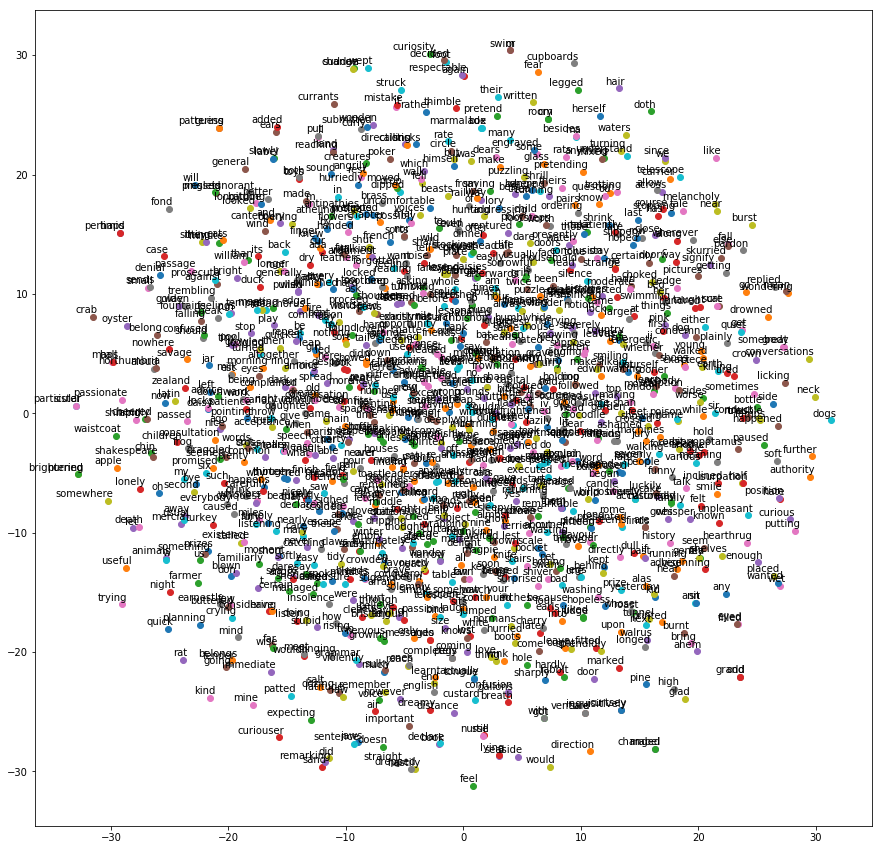

In [66]:
#Visualization results trained word embeddings
vectors = skipgram1.get_weights()[0]
embeddings = TSNE(n_components=2).fit_transform(vectors)

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [dict_tokens_reverse[i] for i in range(1, V)]
plot(embeddings, words)

In [18]:
weights  = cbow1.layers[0].get_weights()[0]
print(weights)

[[  7.39584863e-02  -2.55094707e-01  -3.42178553e-01 ...,  -3.34807992e-01
   -2.28287265e-01  -2.85454184e-01]
 [ -1.45358965e-03   1.33955479e-03  -4.29696701e-02 ...,   2.54817866e-02
   -3.39204893e-02  -2.17791926e-02]
 [  1.92460455e-02  -2.03939080e-02   3.33816931e-03 ...,  -4.39355746e-02
    3.37061621e-02   4.16610278e-02]
 ..., 
 [  2.06082202e-02  -3.02275065e-02   7.82372802e-03 ...,   2.98627354e-02
    3.03066894e-03   2.71470286e-02]
 [  1.90548413e-02   4.85546477e-02   3.45994569e-02 ...,   5.42704016e-03
   -1.86122432e-02  -2.77214404e-02]
 [  2.11739875e-02   3.51507924e-02  -1.66596100e-03 ...,  -6.57662749e-05
   -2.60403398e-02   4.31356318e-02]]


Interpretation results of the visualization

5.Compare the results of the trained word embeddings with the word-word co-occurrence matrix

In [38]:
co_occurrence = KeyedVectors.load_word2vec_format('./vectors_co_occurrence.txt', binary=False)
print(co_occurrence.most_similar(positive=['he', 'her'], negative=['she']))
# he she his her
# king - queen + woman = man
# he - she + her = his



[('herself', 0.5234822034835815), ('and', 0.45863497257232666), ('hurry', 0.45686089992523193), ('went', 0.45646560192108154), ('was', 0.4503447711467743), ('swam', 0.4451175332069397), ('go', 0.4421713650226593), ('going', 0.4310154914855957), ('trying', 0.4295819401741028), ('said', 0.42898356914520264)]


c:\program files\python\lib\site-packages\gensim\models\keyedvectors.py:829: RuntimeWarning: invalid value encountered in true_divide
  self.syn0norm = (self.syn0 / sqrt((self.syn0 ** 2).sum(-1))[..., newaxis]).astype(REAL)


6.Discussion of the advantages of CBOW and Skipgram, the advantages of negative sampling and drawbacks of CBOW and Skipgram

ADVANTAGES CBOW

Designed to learn predict the correct word by a given context. 

DRAWBACK SKIPGRAM <b> You Mean cbow??</b>

Rare words will be ousted by more common words as results due to  infrequency

ADVANTAGES SKIPGRAM

Designed to learn to predict the correct context given a word.

DRAWBACK SKIPGRAM

Needs more data to be able to understand rare /unfrequent words

ADVANTAGES NEGATIVE SAMPLING

The advantages of negative sampling is that not all the weights of the neurons in the network are tweaked in each sample. Only a small percentag of the weights in the network are tweaked. Speeding up the training of the neural network significantly. The other benefit of negative sampling. Negative sampling identifies words that have likely no influence on the label word and set them to 0 by identifying frequent words with the unigram distribution.


In [ ]:
#load pretrained word embeddings of word2vec

path_word2vec = "your path /GoogleNews-vectors-negative300.bin"

word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

In [ ]:
#load pretraind word embeddings of Glove

path = "your path /glove.6B/glove.6B.300d_converted.txt"

#convert GloVe into word2vec format
gensim.scripts.glove2word2vec.get_glove_info(path)
gensim.scripts.glove2word2vec.glove2word2vec(path, "glove_converted.txt")

glove = KeyedVectors.load_word2vec_format(path, binary=False)

In [ ]:
#Visualize the pre-trained word embeddings

Comparison performance with your own trained word embeddings